In [10]:
train만 봄
le 1 e-5로 10배 늘림
값의 제한이 필요함 (0~5) -> 정확도 100% 향상
- L1(MAE)와 L2(MSE)의 결과 차이


MSE : 제곱편차 > 아웃라이어에 민감 > 모델이 문제를 잘 풀지 못하면, 중앙값을 취해 제곱편차를 최대한 줄이려고 함.
MAE : 편차 > 약간의 증거가 보이면 그쪽으로 라벨링을 하는 경항성이, MSE보다 강함.

문제가 쉬우면 MSE를 쓰고 아니면 MAE를 쓴다.


SyntaxError: invalid syntax (1795262606.py, line 1)

In [ ]:
import os

import json

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm
from transformers import AutoTokenizer

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# label의 분포를 box plot으로 그립니다
def draw_box_plot(df, epoch):
    label_list = [row['label'] for i, row in df.iterrows()]
    pred_list = [row['pred'] for i, row in df.iterrows()]
    plt.boxplot([label_list, pred_list])
    plt.xticks([1, 2], ['label', 'pred'])
    plt.title(f"Boxplot for target label when epoch {epoch}")
    plt.show()
    
# pandas 데이터를 가지고 그래프를 그리는 함수입니다
def draw_graph(df):
    source_binary = {source:[0, 0] for source in sorted(df['source'].unique())}
    for i, item in df.iterrows():
        source_binary[item['source']][item['binary_label']] += 1
    source_binary_df = pd.DataFrame(source_binary).transpose()

    # source의 분포
    df['source'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # source별 binary label의 분포
    source_binary_df.plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # label의 분포
    df['label'].plot(kind='hist', rot=20, figsize=(8, 6))
    plt.show()
    # binary label의 분포
    df['binary_label'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    

def matching_plot(df):
    # Matching Plot
    
    _x = np.arange(len(df['label']))
    index = df['label'].sort_values().index
    plt.figure(figsize=(20,4))
    plt.plot(_x, df['pred'][index], 'rx', label='prediction')
    plt.plot(_x, df['label'][index], 'g+', label='label')
    plt.legend()
    plt.show()

0         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.359433
std    2691.751289     1.602212     0.384981
min       0.000000     0.000000    -0.153550
25%    2330.750000     0.200000     1.204493
50%    4661.500000     1.600000     1.453999
75%    6992.250000     3.400000     1.624391
max    9323.000000     5.000000     2.150618


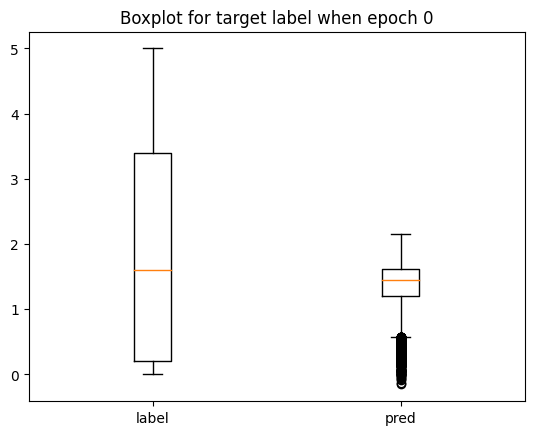

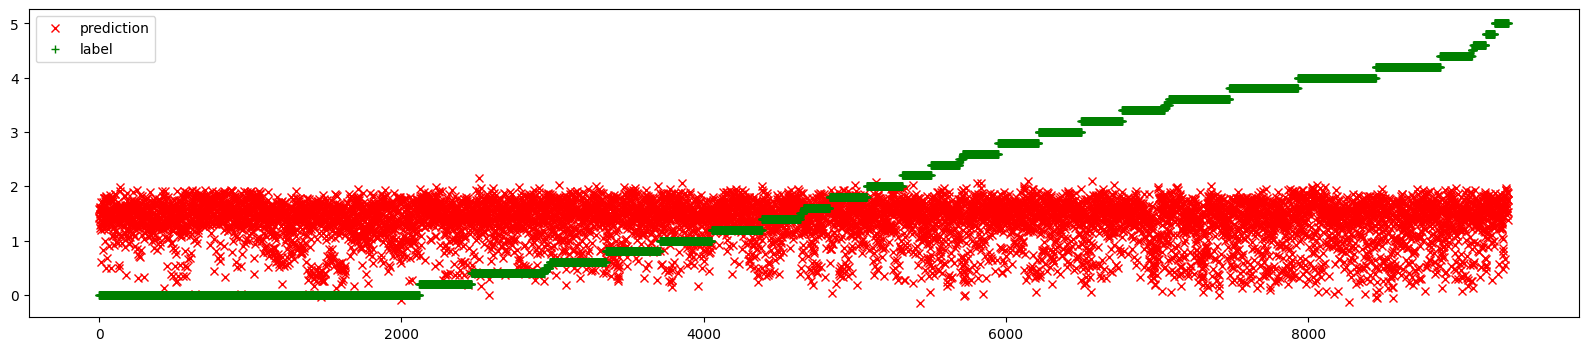

3         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.516960
std    2691.751289     1.602212     0.313160
min       0.000000     0.000000     0.094564
25%    2330.750000     0.200000     1.304169
50%    4661.500000     1.600000     1.517208
75%    6992.250000     3.400000     1.726882
max    9323.000000     5.000000     2.670305


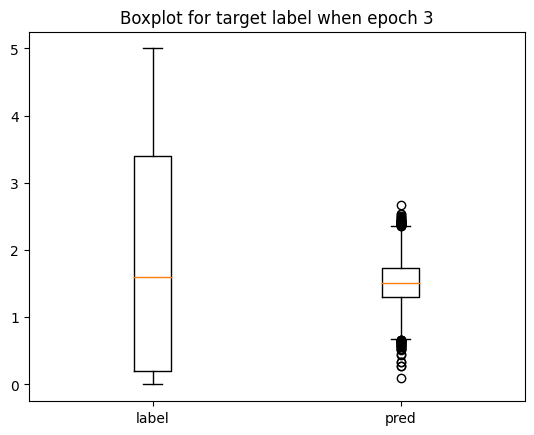

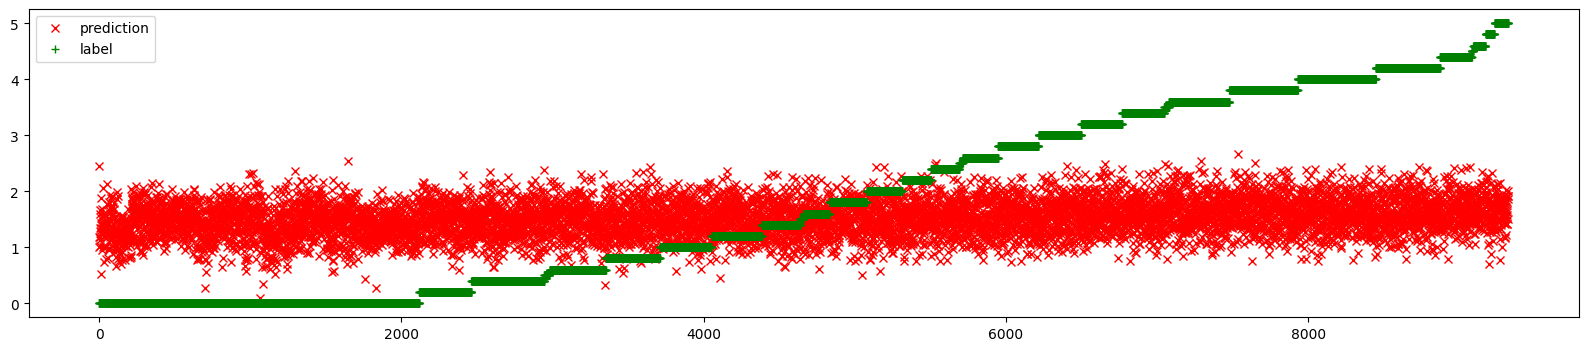

6         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.655284
std    2691.751289     1.602212     0.754420
min       0.000000     0.000000    -0.421784
25%    2330.750000     0.200000     1.111762
50%    4661.500000     1.600000     1.632323
75%    6992.250000     3.400000     2.197974
max    9323.000000     5.000000     4.007438


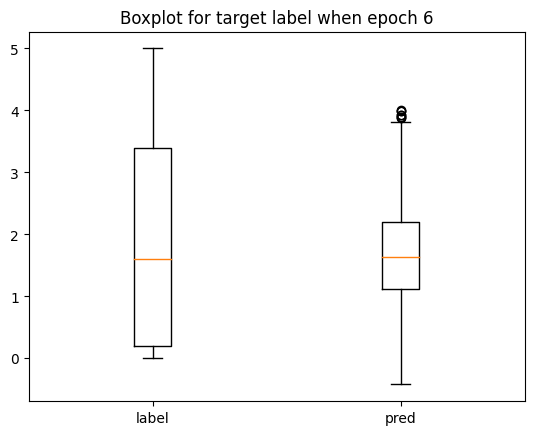

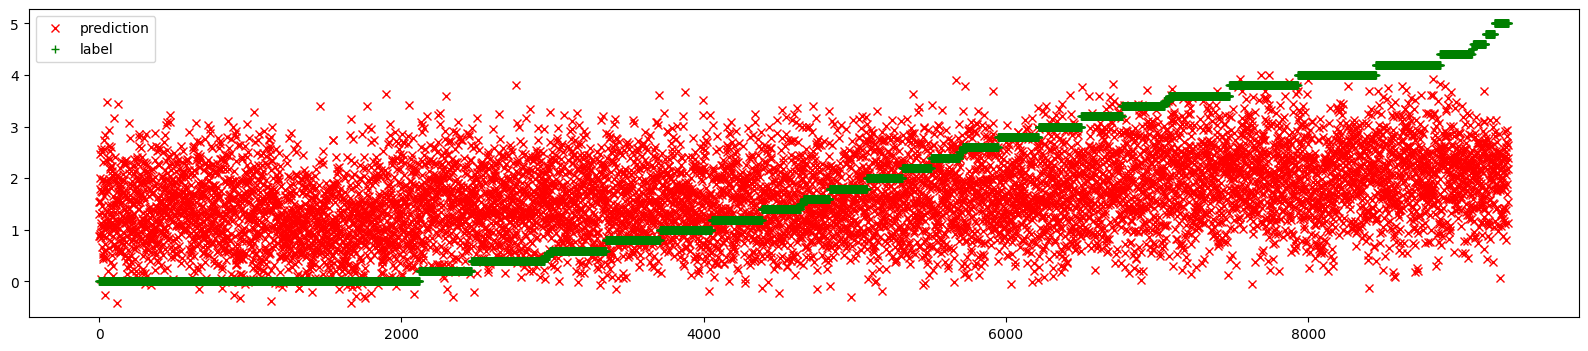

9         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.662782
std    2691.751289     1.602212     0.913965
min       0.000000     0.000000    -0.675471
25%    2330.750000     0.200000     0.969913
50%    4661.500000     1.600000     1.587941
75%    6992.250000     3.400000     2.303593
max    9323.000000     5.000000     4.659244


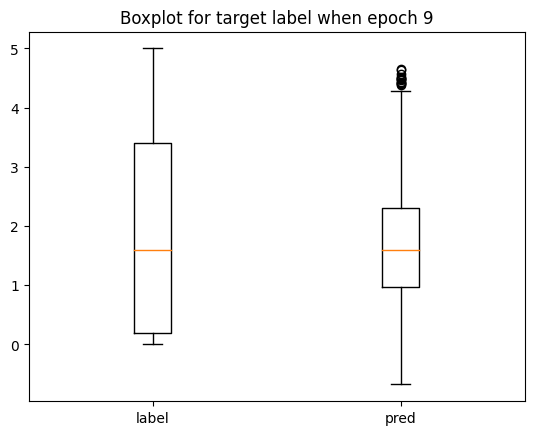

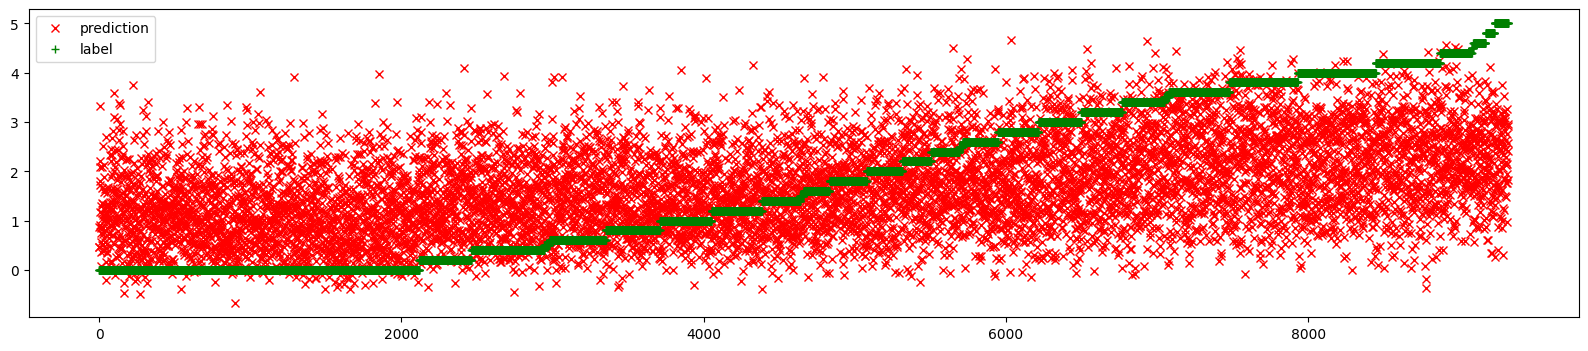

12         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.682083
std    2691.751289     1.602212     1.029687
min       0.000000     0.000000    -0.705526
25%    2330.750000     0.200000     0.871626
50%    4661.500000     1.600000     1.567965
75%    6992.250000     3.400000     2.407611
max    9323.000000     5.000000     5.202668


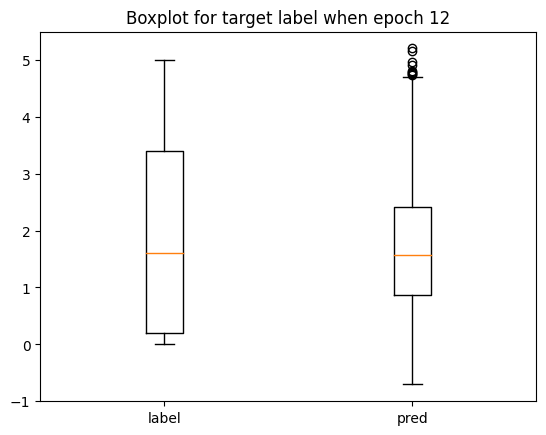

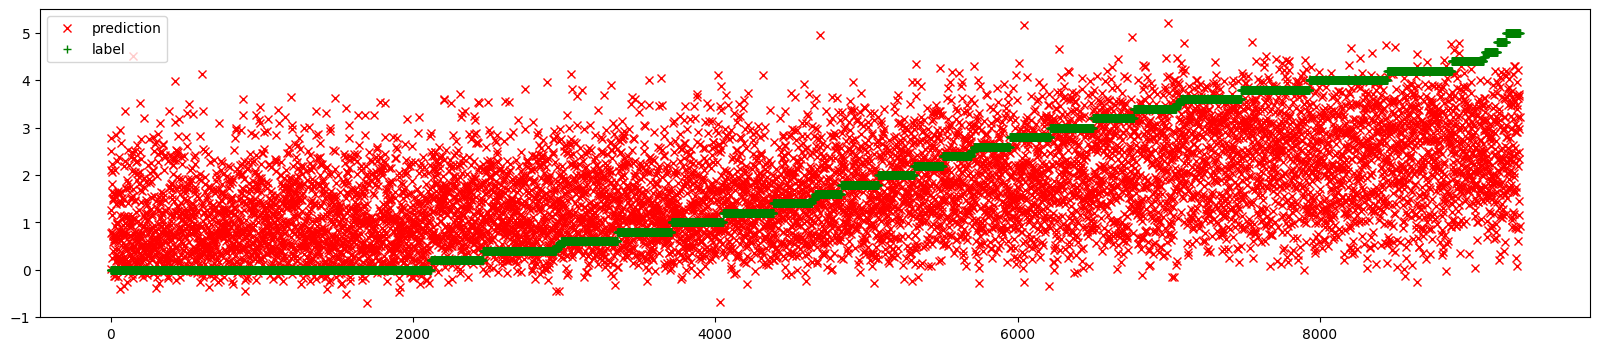

15         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.706329
std    2691.751289     1.602212     1.097076
min       0.000000     0.000000    -0.754895
25%    2330.750000     0.200000     0.809524
50%    4661.500000     1.600000     1.586269
75%    6992.250000     3.400000     2.502427
max    9323.000000     5.000000     5.226959


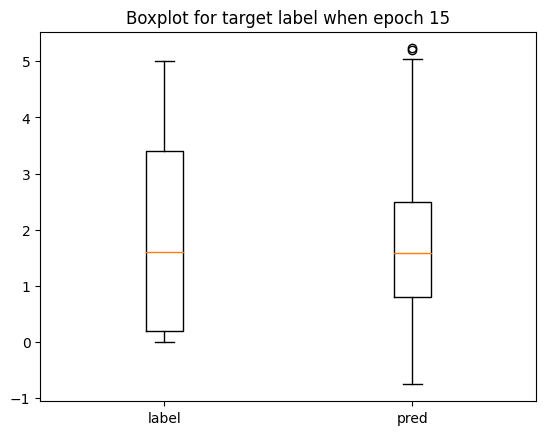

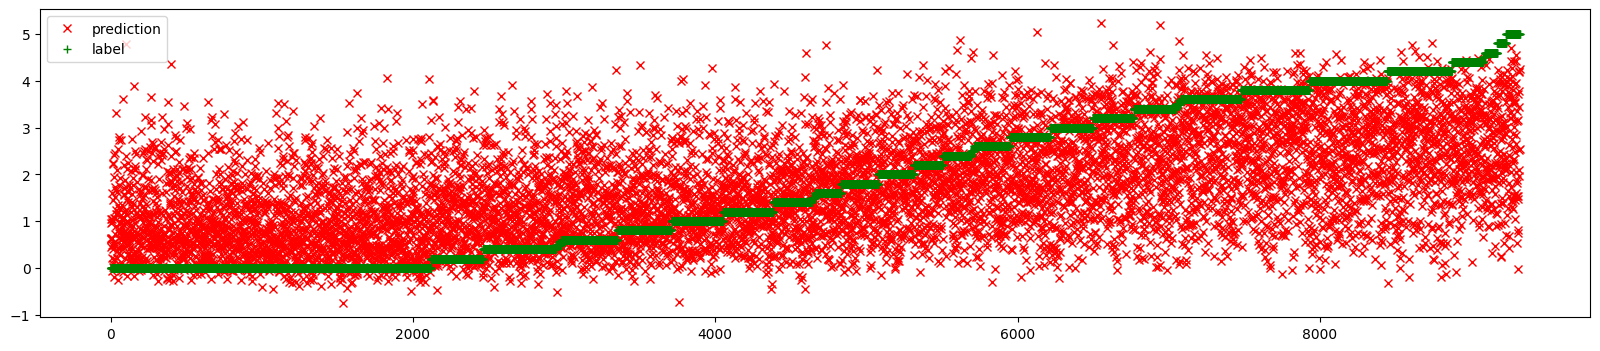

18         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.717612
std    2691.751289     1.602212     1.133888
min       0.000000     0.000000    -0.820530
25%    2330.750000     0.200000     0.788029
50%    4661.500000     1.600000     1.583744
75%    6992.250000     3.400000     2.578134
max    9323.000000     5.000000     5.277237


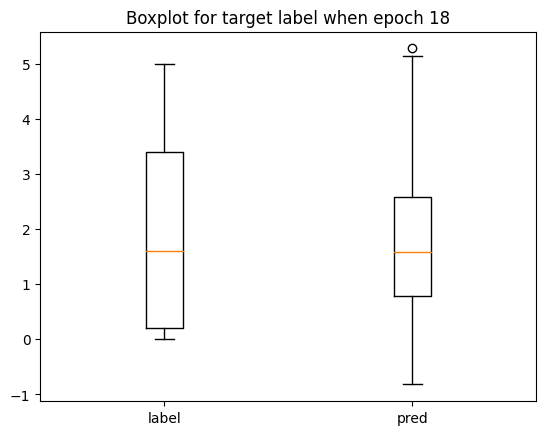

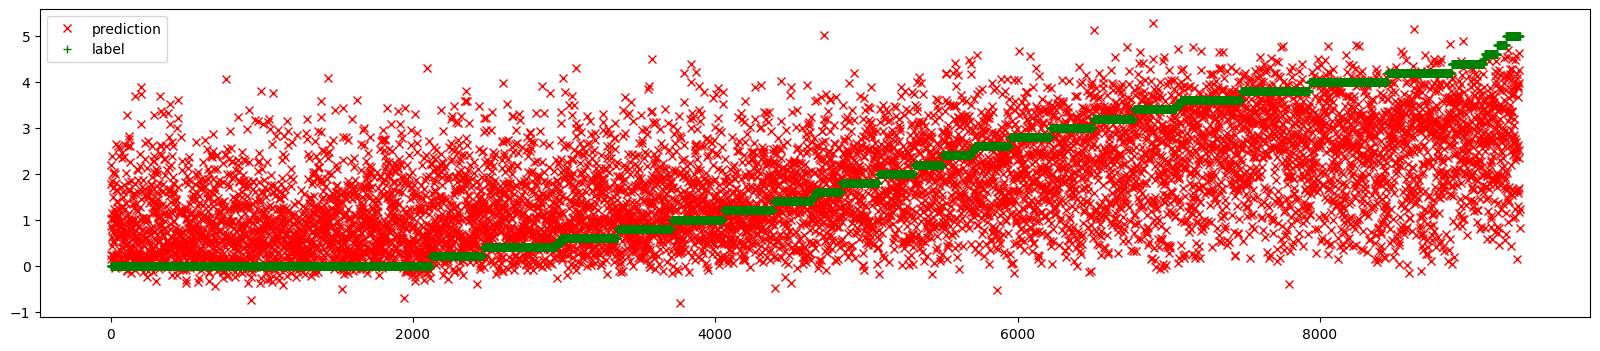

21         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.709605
std    2691.751289     1.602212     1.175412
min       0.000000     0.000000    -0.542441
25%    2330.750000     0.200000     0.727183
50%    4661.500000     1.600000     1.539768
75%    6992.250000     3.400000     2.615066
max    9323.000000     5.000000     5.436287


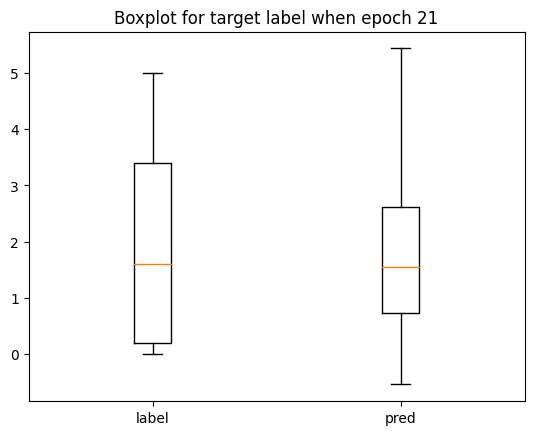

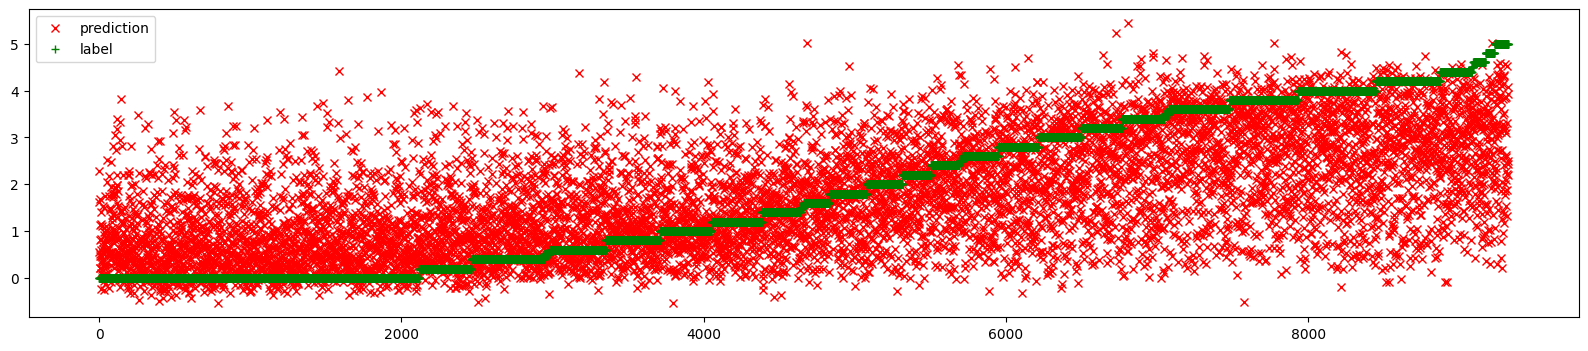

24         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.724544
std    2691.751289     1.602212     1.215320
min       0.000000     0.000000    -0.818384
25%    2330.750000     0.200000     0.691403
50%    4661.500000     1.600000     1.546050
75%    6992.250000     3.400000     2.731133
max    9323.000000     5.000000     5.335660


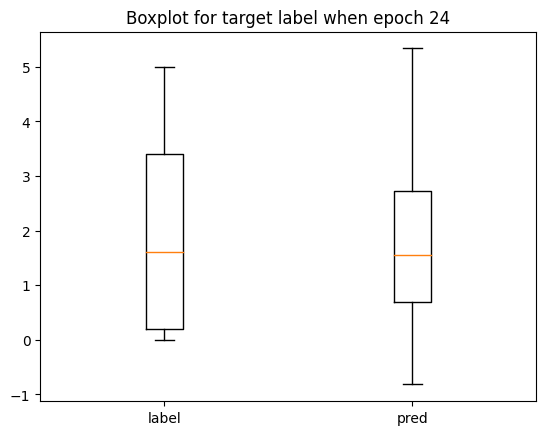

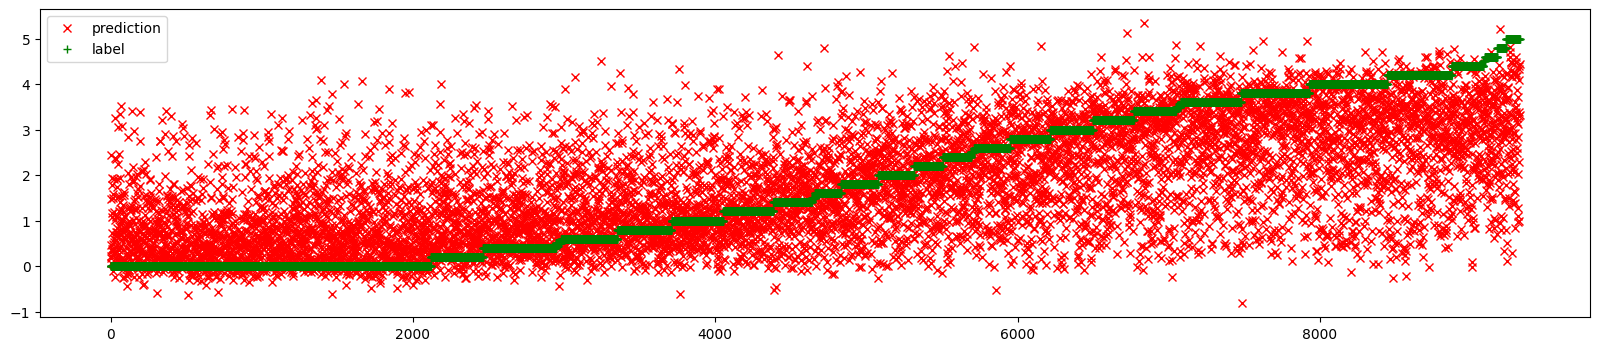

27         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.743841
std    2691.751289     1.602212     1.258399
min       0.000000     0.000000    -0.827649
25%    2330.750000     0.200000     0.654852
50%    4661.500000     1.600000     1.544435
75%    6992.250000     3.400000     2.812553
max    9323.000000     5.000000     5.346602


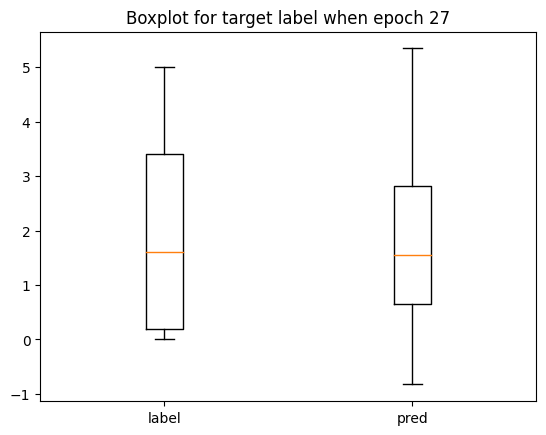

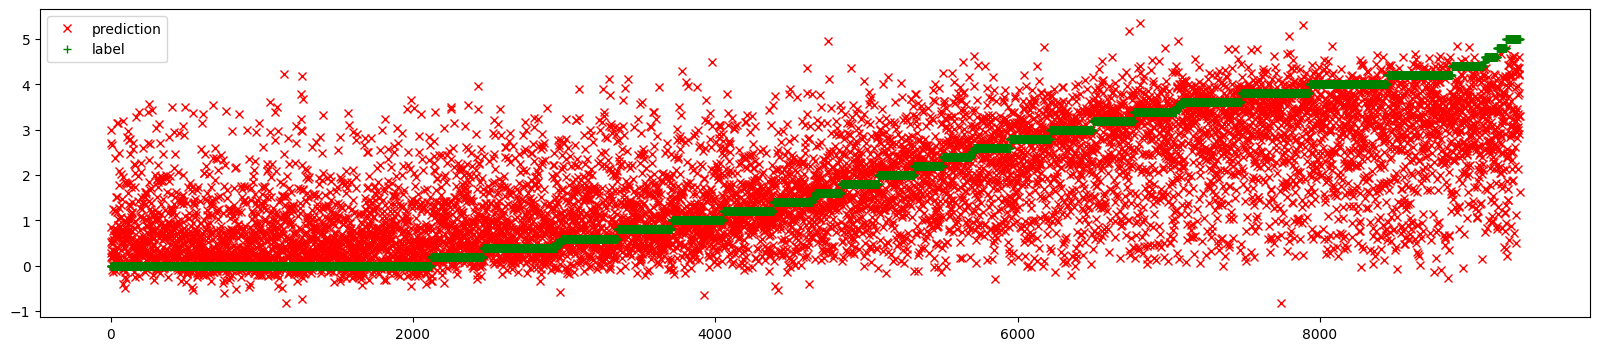

30         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.752666
std    2691.751289     1.602212     1.286544
min       0.000000     0.000000    -0.822973
25%    2330.750000     0.200000     0.615881
50%    4661.500000     1.600000     1.549833
75%    6992.250000     3.400000     2.848756
max    9323.000000     5.000000     5.621139


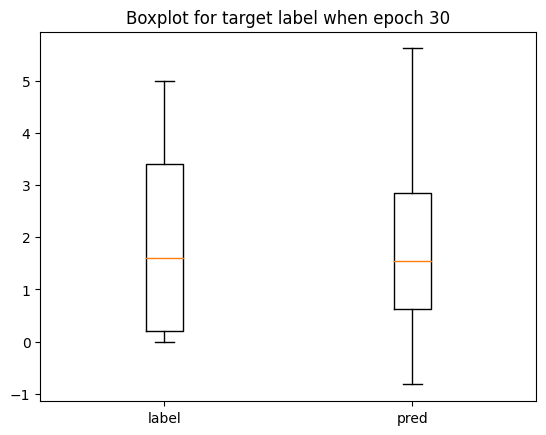

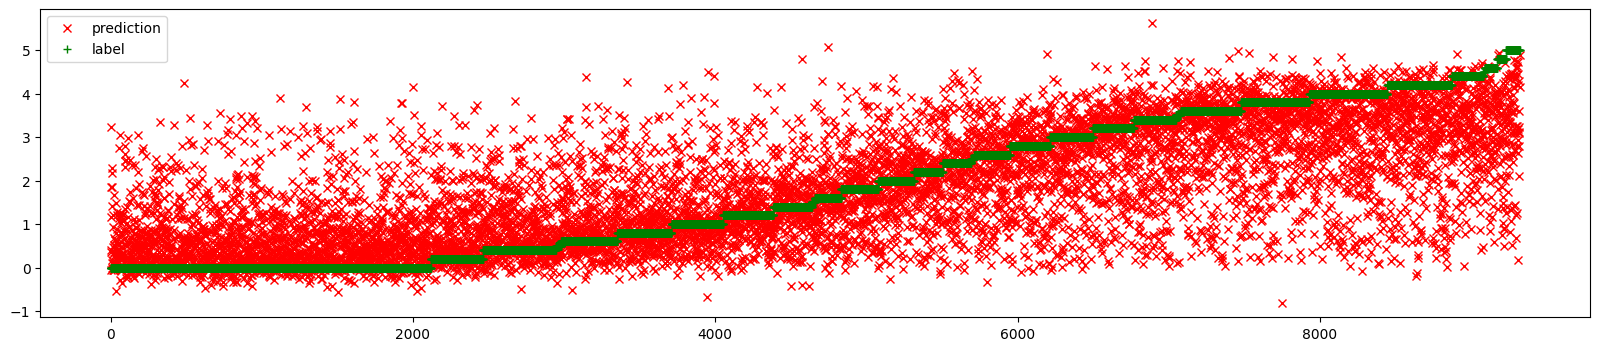

33         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.753284
std    2691.751289     1.602212     1.324743
min       0.000000     0.000000    -0.754509
25%    2330.750000     0.200000     0.566474
50%    4661.500000     1.600000     1.528988
75%    6992.250000     3.400000     2.924803
max    9323.000000     5.000000     5.372307


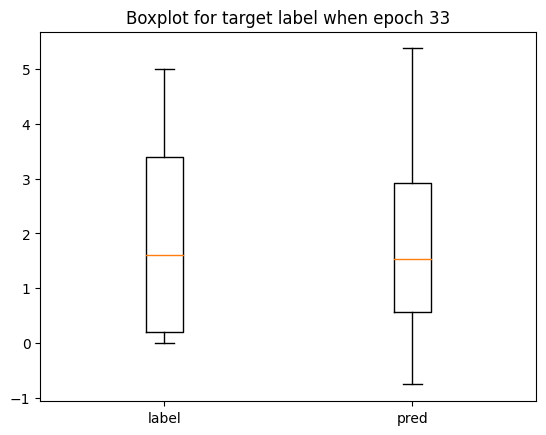

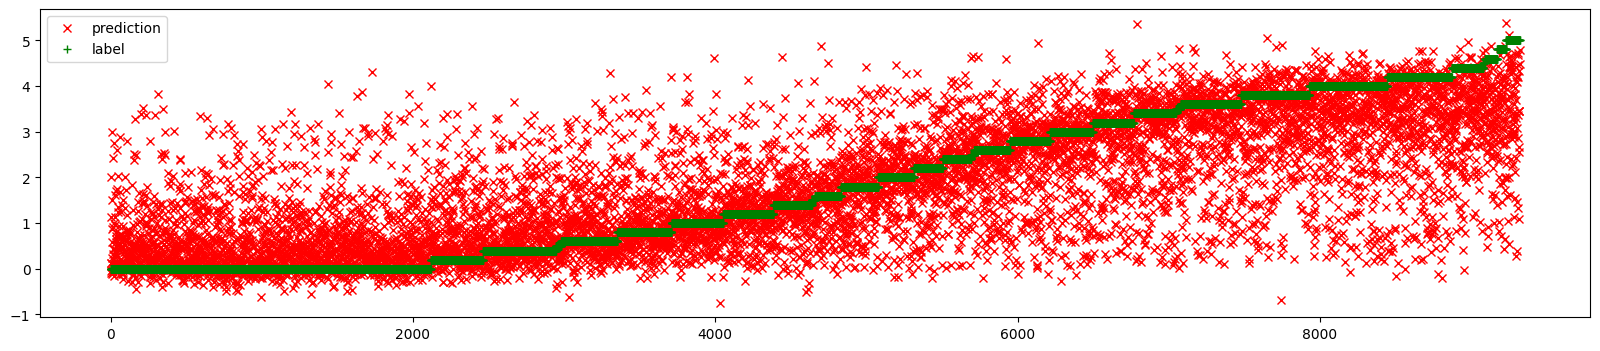

36         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.748032
std    2691.751289     1.602212     1.344384
min       0.000000     0.000000    -0.790575
25%    2330.750000     0.200000     0.538447
50%    4661.500000     1.600000     1.486789
75%    6992.250000     3.400000     2.961993
max    9323.000000     5.000000     5.614342


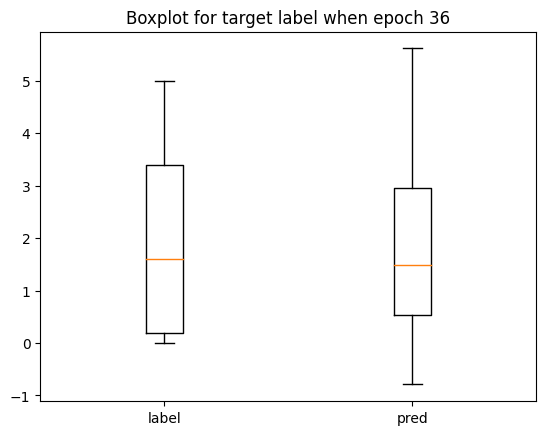

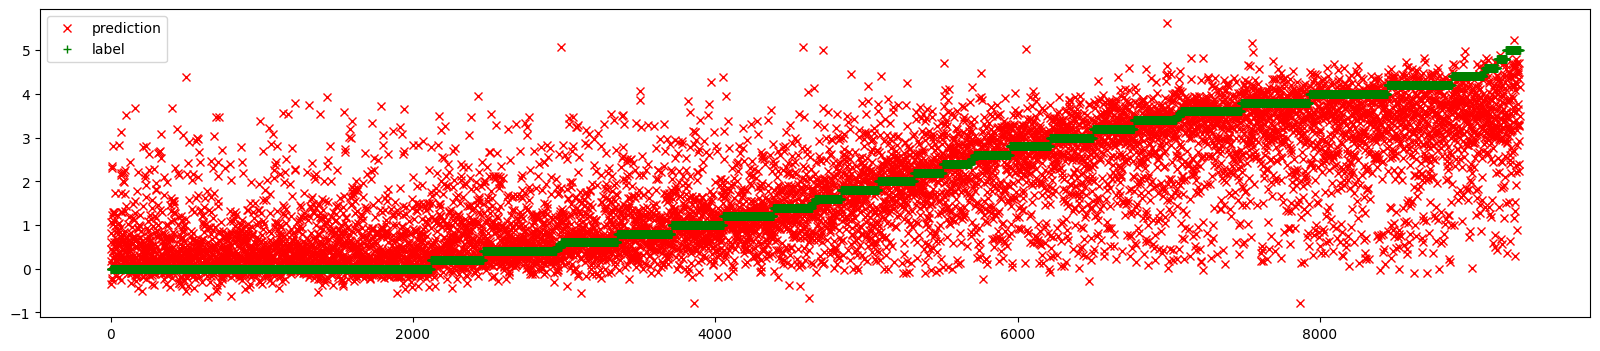

39         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.769200
std    2691.751289     1.602212     1.368687
min       0.000000     0.000000    -0.812931
25%    2330.750000     0.200000     0.530999
50%    4661.500000     1.600000     1.508835
75%    6992.250000     3.400000     3.027348
max    9323.000000     5.000000     5.419982


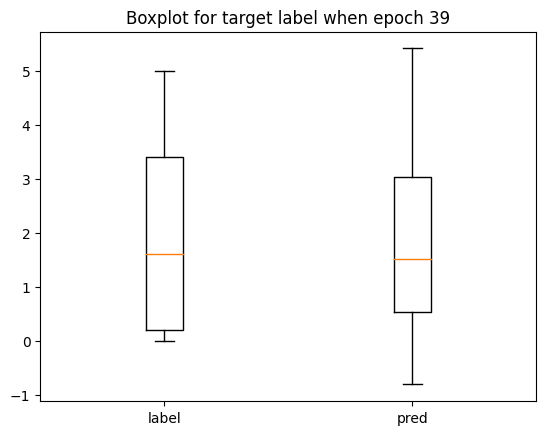

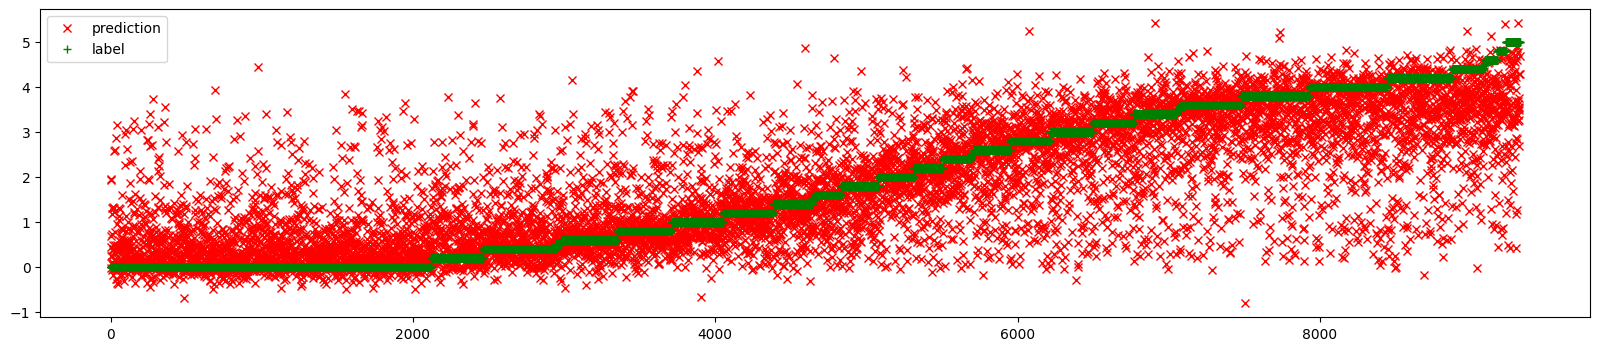

42         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.777052
std    2691.751289     1.602212     1.386568
min       0.000000     0.000000    -0.692041
25%    2330.750000     0.200000     0.510352
50%    4661.500000     1.600000     1.506395
75%    6992.250000     3.400000     3.052173
max    9323.000000     5.000000     5.357916


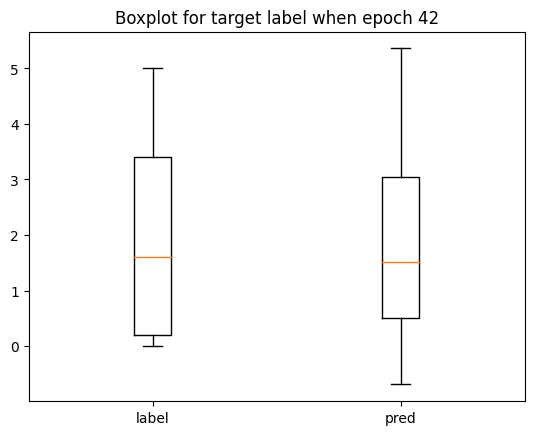

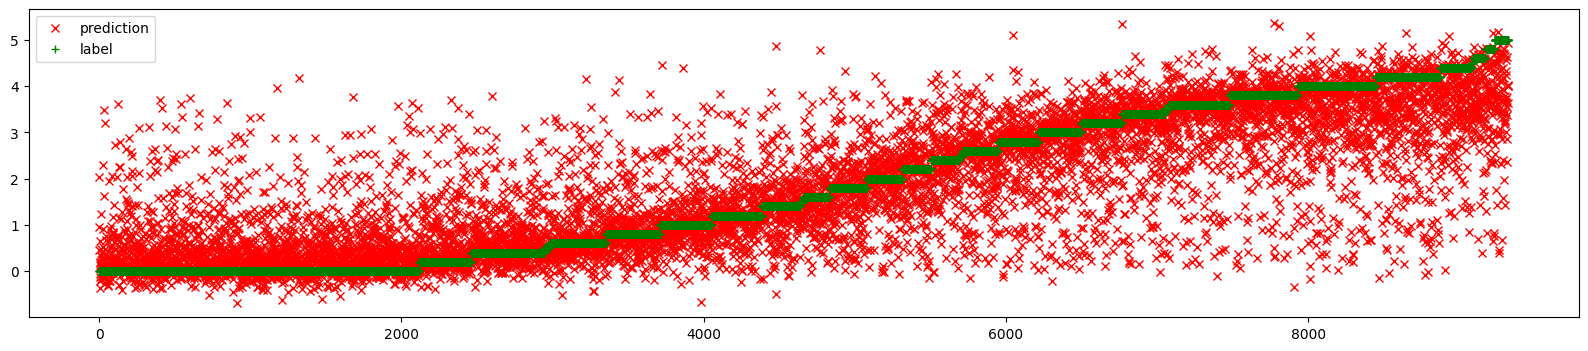

45         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.779198
std    2691.751289     1.602212     1.403778
min       0.000000     0.000000    -0.582915
25%    2330.750000     0.200000     0.489059
50%    4661.500000     1.600000     1.501212
75%    6992.250000     3.400000     3.082336
max    9323.000000     5.000000     5.514555


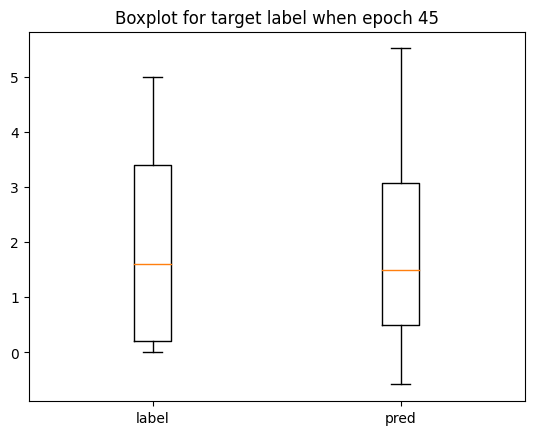

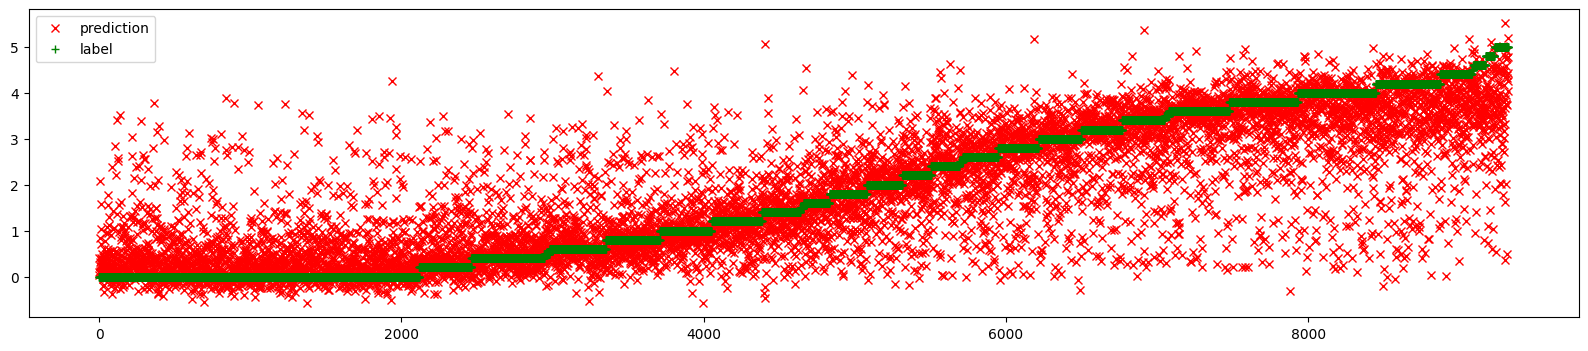

48         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.777848
std    2691.751289     1.602212     1.421735
min       0.000000     0.000000    -0.857840
25%    2330.750000     0.200000     0.449956
50%    4661.500000     1.600000     1.509860
75%    6992.250000     3.400000     3.097902
max    9323.000000     5.000000     5.563049


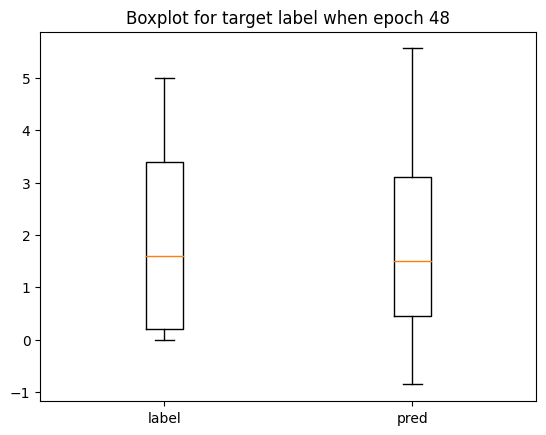

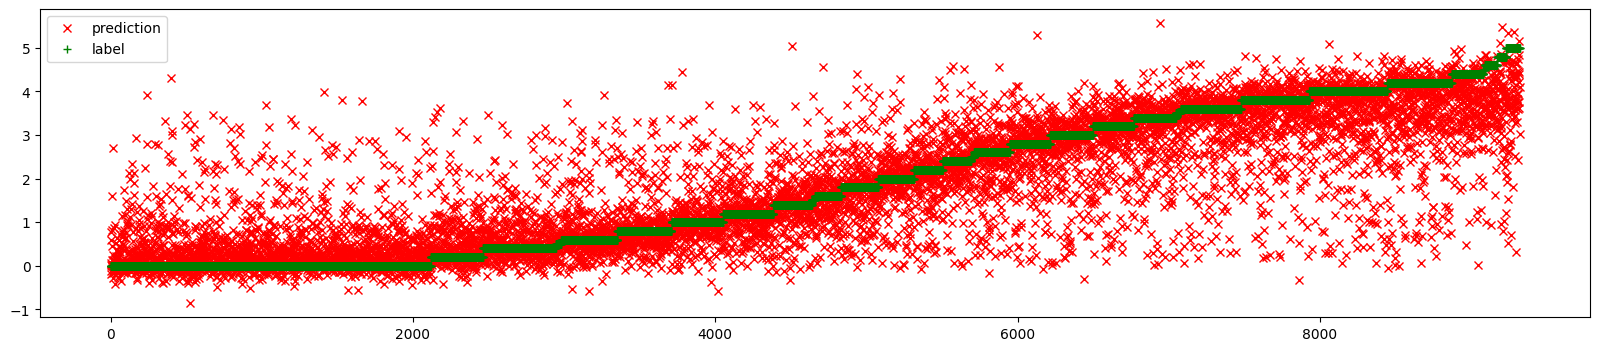

49         Unnamed: 0        label         pred
count  9324.000000  9324.000000  9324.000000
mean   4661.500000     1.849968     1.778064
std    2691.751289     1.602212     1.428196
min       0.000000     0.000000    -0.934569
25%    2330.750000     0.200000     0.448144
50%    4661.500000     1.600000     1.516070
75%    6992.250000     3.400000     3.109680
max    9323.000000     5.000000     5.460232


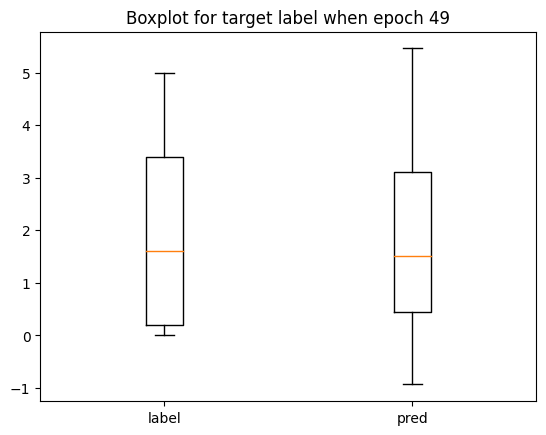

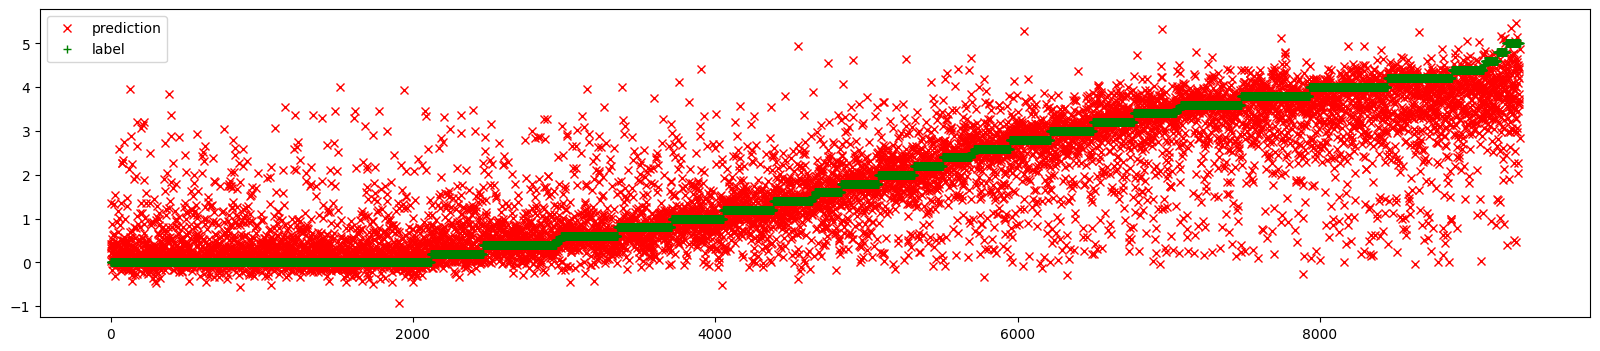

In [12]:
epoch = len(os.listdir('output'))
for e in range(epoch):
    if e == epoch-1 or e % 3 == 0:
        data = pd.read_csv(f'output/{e}.csv')
        print(e, data.describe())
        draw_box_plot(data, e)
        matching_plot(data)